# The Habitual Action Network

Habitual network

Assuming generative model is perfect, then action selected would always be the action that maximises chance of observing prior preferences. Hence habitual network can be trained to output maximally rewarding actions, as these actions are the free energy minimising actions.

Also has a nice interpretation as long as the generative models keep training. Eventually the generative model is less sure about old things. Why people eventually revisit old states they were previously certain about.

As far as an agent knows, if observations are confirming perfectly to expectations then it has a perfect world model. So why would it change it? It’s only when an uncertain observation comes in that the agent needs to reconsider whether or not it has the best model of the world.


I think this network should be performing policy gradient method but instead of minimising the discounted reward sequence it should minimise the discounted external EFE/FEEF component sequence. That way in the end the end the fast and slow thinking methods should be converging as the world model continues to improve


What is this network trying to learn?
- This network is trying to learn the state action mapping that maximises the probability of being in the preferred states
- It is also trying to learn to output actions that maximise the extrinsic part of the EFE/FEEF


What does this network take as input?
- Current state
- Maybe sequence of previous states and actions

What should this network output?
- The action that leads to the next state that maximally achieves the prior preferences

How should this network learn?
- It should learn by outputting



In [1]:
from util import random_observation_sequence, transform_observations
import matplotlib.pyplot as plt
import gym

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [3]:
class HabitualAction(keras.Model):

    def __init__(self, latent_dim, action_dim, planning_horizon, dense_units, action_std_dev=0.05, **kwargs):
        super(HabitualAction, self).__init__(**kwargs)

        habit_action_inputs = layers.Input(latent_dim)
        h = habit_action_inputs
        for d in dense_units:
            h = layers.Dense(d, activation="relu")(h)

        a_mean = layers.Dense(action_dim, activation="tanh", name="z_mean")(h)
        # a_log_sd = layers.Dense(action_dim, name="z_log_var")(h)
        # a_stddev = tf.exp(a_log_sd)

        # self.habit_action_model = keras.Model(habit_action_inputs, [a_mean, a_stddev], name="habit_action")
        self.habit_action_model = keras.Model(habit_action_inputs, a_mean, name="habit_action")

        # add the loss over all time steps
        self.loss_tracker = keras.metrics.Sum(name="loss")

        self.action_std_dev = action_std_dev

    def call(self, inputs, training=None, mask=None):
        return self.habit_action_model(inputs)


    @property
    def metrics(self):
        return [self.loss_tracker]


    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.

        latent_states, outcomes = data
        true_actions, cum_discounted_rewards = outcomes

        # TODO what do I assume the
        with tf.GradientTape() as tape:
            # a_mean, a_stddev = self.habit_action_model(latent_states, training=True)  # Forward pass
            a_mean = self.habit_action_model(latent_states, training=True)  # Forward pass

            print(a_mean, true_actions)

            log_loss = ll_gaussian(a_mean, true_actions, self.action_std_dev**2, use_consts=False)
            weighted_log_loss = log_loss * cum_discounted_rewards

            # need to multiply by negative one because neural net does gradient descent not ascent
            neg_weighted_log_loss = -1 * weighted_log_loss

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(neg_weighted_log_loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.loss_tracker.update_state(neg_weighted_log_loss)
        return {
            "loss": self.loss_tracker.result()
        }


def compute_discounted_cumulative_reward(rewards, discount_factor):

    gamma = np.ones_like(rewards) * discount_factor
    # print(gamma.shape)
    gamma_t = np.power(gamma, np.arange(rewards.shape[0]).reshape(rewards.shape[0], 1))  # discounted through time

    # print(gamma_t)
    # print(gamma_t.shape)

    # discounted rewards starting from the start
    discounted_rewards = np.multiply(rewards, gamma_t)

    # print(rewards)
    # print(discounted_rewards)

    n = rewards.shape[0]

    # upper trianglur matrix with row i equal to 1/(discount_factor**i)  indexing from 0
    discount_factor_matrix = (np.tril(np.ones((n,n))) * (1/gamma_t)).T
    discount_factor_matrix

    # cumulative discounted_rewards
    cumulative_discounted_rewards = np.matmul(discount_factor_matrix, discounted_rewards)
    return cumulative_discounted_rewards



def ll_gaussian(pred, target, variance, use_consts=True):

    log_prob = -1 * ((pred - target)**2/(2*variance))

    if use_consts:
        const = 0.5*np.log(2*np.pi*variance)
        log_prob += const

    return tf.reduce_sum(log_prob, axis=1)

In [4]:
gamma = np.ones(5)*0.99
rewards = np.array([-1,-1,-1,-1, 1]).reshape((5,1))
gamma_t = np.power(gamma, np.arange(rewards.shape[0]))
gamma_t

array([1.        , 0.99      , 0.9801    , 0.970299  , 0.96059601])

In [5]:
env = gym.make('MountainCarContinuous-v0')
env.action_space.seed(42)

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

all_observations = []
all_observations_scaled = []
actions = []
rewards = []
num_episodes = 1

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]

t_max = 200

for i in range(num_episodes):
    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    # o_scaled = transform_observations(o, observation_max, observation_min, obs_stddev)
    o_scaled = o
    actions.append(a)

    rewards.append(r)

    # o = transform_observations(o, observation_max, observation_min, [0, 0])

    all_observations_scaled.append(o_scaled)
    all_observations.append(o[:-1])

all_observations = np.vstack(all_observations)
all_observations_scaled = np.vstack(all_observations_scaled)
actions = np.vstack(actions)
rewards = np.vstack(rewards).T
# rewards = rewards.reshape(rewards.shape[0])
print(all_observations.shape, actions.shape, rewards.shape)

(200, 2) (200, 1) (200, 1)


In [6]:
all_observations

array([[-4.13707405e-01,  0.00000000e+00],
       [-4.14563715e-01, -8.56321130e-04],
       [-4.16270286e-01, -1.70656305e-03],
       [-4.18814957e-01, -2.54467386e-03],
       [-4.22179610e-01, -3.36465752e-03],
       [-4.26340222e-01, -4.16060397e-03],
       [-4.31266934e-01, -4.92672157e-03],
       [-4.36924309e-01, -5.65737346e-03],
       [-4.41962123e-01, -5.03781904e-03],
       [-4.46343809e-01, -4.38167900e-03],
       [-4.50037420e-01, -3.69360554e-03],
       [-4.53015953e-01, -2.97853583e-03],
       [-4.55257595e-01, -2.24164734e-03],
       [-4.56745893e-01, -1.48831040e-03],
       [-4.58786398e-01, -2.04051589e-03],
       [-4.61364120e-01, -2.57771532e-03],
       [-4.64460045e-01, -3.09593184e-03],
       [-4.68051344e-01, -3.59131279e-03],
       [-4.72111493e-01, -4.06015664e-03],
       [-4.76387978e-01, -4.27649496e-03],
       [-4.80849087e-01, -4.46111104e-03],
       [-4.85461652e-01, -4.61257296e-03],
       [-4.90191340e-01, -4.72969515e-03],
       [-4.

In [7]:
act_net = HabitualAction(2, 1, 10, [100])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 100)               300       
                                                                 
 z_mean (Dense)              (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [8]:
# act_net.fit(all_observations, (actions, cum_rewards), batch_size=all_observations.shape[0], epochs=100)

# act_net.train_on_batch(all_observations, (actions, cum_rewards))

## How about multiple runs?

In [9]:
act_net = HabitualAction(2, 1, 10, [20, 20])

act_net.compile(optimizer=tf.keras.optimizers.Adam())

act_net.habit_action_model.summary()

Model: "habit_action"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 20)                60        
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 z_mean (Dense)              (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [10]:
t_max = 1000
num_episodes = 250

for i in range(num_episodes):

    all_observations = []
    actions = []
    rewards = []

    o, a, r = random_observation_sequence(env, t_max, epsilon=0.1)
    # o_scaled = transform_observations(o, observation_max, observation_min, [0.05, 0.05])
    o = transform_observations(o, observation_max, observation_min, obs_stddev)
    actions.append(a)
    rewards.append(r)

    all_observations.append(o[:-1])

    all_observations = np.vstack(all_observations)
    all_observations_scaled = np.vstack(all_observations_scaled)
    actions = np.vstack(actions)
    rewards = np.vstack(rewards).T
    # rewards = rewards.reshape(rewards.shape[1])

    # print(all_observations.shape, actions.shape, rewards.shape)

    cum_rewards = compute_discounted_cumulative_reward(rewards, 0.99)
    # cum_rewards

    cum_rewards = cum_rewards

    # print(cum_rewards.shape[0])
    loss = act_net.train_on_batch(all_observations, (actions, cum_rewards))
    print(loss)

Tensor("habit_action/z_mean/Tanh:0", shape=(803, 1), dtype=float32) Tensor("IteratorGetNext:1", shape=(803, 1), dtype=float32)
Tensor("habit_action/z_mean/Tanh:0", shape=(803, 1), dtype=float32) Tensor("IteratorGetNext:1", shape=(803, 1), dtype=float32)
3810164480.0
Tensor("habit_action/z_mean/Tanh:0", shape=(387, 1), dtype=float32) Tensor("IteratorGetNext:1", shape=(387, 1), dtype=float32)
809458048.0
Tensor("habit_action/z_mean/Tanh:0", shape=(None, 1), dtype=float32) Tensor("IteratorGetNext:1", shape=(None, 1), dtype=float32)


2022-08-23 15:05:07.393665: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


741325824.0
5002441728.0
411475840.0
-672789376.0
959866624.0
556951296.0
640797440.0
4897180672.0
1762817024.0
222622416.0
2532931328.0
1175451520.0
1102832640.0
190986928.0
693313728.0
147131168.0
1427008000.0
733771456.0
164166160.0
460739328.0
879793216.0
577780736.0
3289129216.0
2244201728.0
934701312.0
326885696.0
5469630464.0
4230863104.0
609048960.0
3199848960.0
140247168.0
2505379584.0
118448136.0
256578416.0
404302464.0
4673155072.0
2608010752.0
410805824.0
173007392.0
1365113600.0
2572195840.0
1739176960.0
1833107456.0
1136237824.0
565774656.0
-990277632.0
-1123750912.0
-1056337472.0
131900544.0
2920847360.0
1316939264.0
-917056448.0
89384384.0
1075774336.0
2101997184.0
499278688.0
342216832.0
313640704.0
1336166016.0
-711653632.0
-808329024.0
1166472576.0
798263424.0
-908910976.0
3547071488.0
3888150272.0
4091119872.0
5233551360.0
2633767424.0
354448128.0
3014722560.0
375080512.0
2157673216.0
-467630752.0
1707118208.0
-1181191296.0
589459520.0
287038976.0
3091329280.0
15194

In [11]:
act_net(all_observations)

<tf.Tensor: shape=(678, 1), dtype=float32, numpy=
array([[-2.25654542e-02],
       [-2.38488428e-02],
       [-2.52445098e-02],
       [-2.66693532e-02],
       [-2.81127188e-02],
       [-2.95637622e-02],
       [-3.10116690e-02],
       [-3.24455984e-02],
       [-3.38548534e-02],
       [-3.52289230e-02],
       [-3.65575776e-02],
       [-3.78309414e-02],
       [-3.90395485e-02],
       [-4.01744731e-02],
       [-4.12273593e-02],
       [-4.21904474e-02],
       [-4.30566408e-02],
       [-3.72288600e-02],
       [-3.10961269e-02],
       [-2.51452811e-02],
       [-1.81959886e-02],
       [-1.12311477e-02],
       [-3.68169602e-03],
       [ 9.48200654e-03],
       [ 2.26804614e-02],
       [ 3.58056352e-02],
       [ 4.88026142e-02],
       [ 6.16999194e-02],
       [ 7.22329021e-02],
       [ 8.12345296e-02],
       [ 8.99222046e-02],
       [ 9.81372073e-02],
       [ 1.05857685e-01],
       [ 9.89551693e-02],
       [ 9.08214077e-02],
       [ 8.72167051e-02],
       [ 8.291

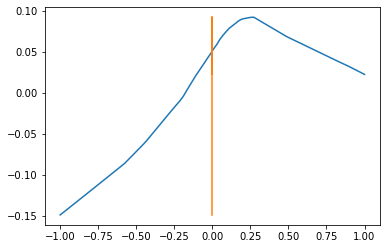

In [12]:
obs_pos = np.vstack([np.linspace(-1, 1, 100), np.zeros(100)]).T
actions_pred = act_net(obs_pos)

actions_pred


plt.plot(obs_pos, actions_pred)

tf.Tensor(
[[-0.25044248]
 [-0.24634488]
 [-0.24223854]
 [-0.23812342]
 [-0.23399977]
 [-0.22986773]
 [-0.2257273 ]
 [-0.22157873]
 [-0.21741652]
 [-0.21315154]
 [-0.20887828]
 [-0.20459718]
 [-0.20030816]
 [-0.19601145]
 [-0.1917072 ]
 [-0.18739559]
 [-0.18307666]
 [-0.17875075]
 [-0.17441785]
 [-0.17007822]
 [-0.1657319 ]
 [-0.16137923]
 [-0.1570203 ]
 [-0.15265517]
 [-0.14828409]
 [-0.14390723]
 [-0.13952476]
 [-0.13513678]
 [-0.13074346]
 [-0.12614667]
 [-0.12122537]
 [-0.1162981 ]
 [-0.11136515]
 [-0.10642662]
 [-0.1013028 ]
 [-0.09591065]
 [-0.09051283]
 [-0.08510972]
 [-0.07970157]
 [-0.07428877]
 [-0.0681168 ]
 [-0.06182038]
 [-0.05551907]
 [-0.04785036]
 [-0.03901978]
 [-0.02949328]
 [-0.01505133]
 [ 0.00373974]
 [ 0.02596716]
 [ 0.04135086]
 [ 0.05567277]
 [ 0.0678949 ]
 [ 0.07700461]
 [ 0.0871534 ]
 [ 0.09775699]
 [ 0.10833845]
 [ 0.11881272]
 [ 0.12913631]
 [ 0.13887256]
 [ 0.14858198]
 [ 0.15826286]
 [ 0.16768046]
 [ 0.17674321]
 [ 0.18577607]
 [ 0.19482212]
 [ 0.20359683]

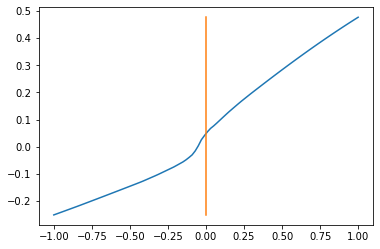

In [13]:
vel_pos = np.vstack([np.zeros(100), np.linspace(-1, 1, 100)]).T
actions_pred = act_net(vel_pos)
print(actions_pred)

plt.plot(obs_pos, actions_pred)

## Can it solve the environment?

In [13]:
num_episodes = 10

observation_max = np.array([0.6, 0.07])
observation_min = np.array([-1.2, -0.07])

# obs_stddev = [0.05, 0.05]
obs_stddev = [0, 0]


t_max = 1000

for i in range(num_episodes):

    env = gym.make('MountainCarContinuous-v0')

    obs = env.reset()

    done = False
    rewards = []

    t = 0
    while not done:

        env.render()

        obs = obs.reshape(1, obs.shape[0])
        obs = transform_observations(obs, observation_max, observation_min, obs_stddev)

        # print(obs)

        action = act_net(obs)
        action = action.numpy()

        obs, reward, done, info = env.step(action)

        # print(obs)

        rewards.append(reward)

        t += 1

        if t == t_max:
            done = True

    print(t)
    if t < t_max:
        print("success")
    else:
        print("Failure")

    print(np.sum(rewards))
    # print(rewards)




env.close()

762
success
99.20545377010609
747
success
98.81060835096568
505
success
98.96460237112511
831
success
99.14034716394394
658
success
98.91230608623175
873
success
99.01944949716578
782
success
98.82260315444415
672
success
98.81597150803844
503
success
98.98914997008887
681
success
99.14920619863372


In [13]:
n = 50
both = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
both = np.array(both)
both

both_acts = act_net(both)

both_acts

<tf.Tensor: shape=(10000, 1), dtype=float32, numpy=
array([[-0.409816  ],
       [-0.4060031 ],
       [-0.40266117],
       ...,
       [ 0.5045513 ],
       [ 0.50988096],
       [ 0.5151719 ]], dtype=float32)>

In [115]:
n = 50
coords = [[i/n, j/n] for i in range(-1*n, n) for j in range(-1*n, n)]
coords = np.array(coords)
coords


array([[-1.  , -1.  ],
       [-1.  , -0.98],
       [-1.  , -0.96],
       ...,
       [ 0.98,  0.94],
       [ 0.98,  0.96],
       [ 0.98,  0.98]])

In [101]:
x = np.arange(-5, 5.1, 0.5)
y = np.arange(-5, 5.1, 0.5)
X,Y = np.meshgrid(x,y)

X

array([[-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],
       [-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ],